# Survival Analysis: GBM Surviavl


# Readme
The following libraries need to be installed in order to run the source code.

In [1]:
import pandas as pd
import numpy as np, warnings
from pathlib import Path
import os
import sweetviz as sv
from importlib import reload

np.warnings = warnings



In [2]:
# import utility functions
import src.utils as utils

# Note: to run main notebook from root directory, use:
ROOT_DIR = Path('')
# setup OS agnostic pathnames
# ROOT_DIR = Path('..')

import src.DataLoader as DataLoader
reload(DataLoader)

dataLoader = DataLoader.DataLoader(ROOT_DIR)

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate, cross_val_score, RandomizedSearchCV

%matplotlib inline
import matplotlib.pyplot as plt


from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sklearn.utils.class_weight import compute_sample_weight
warnings.filterwarnings('ignore')
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis

In [4]:
import joblib

##### 1.1 Data Cleaning

In [5]:
df_desc_icd, df_desc_labitems, df_desc_items = dataLoader.load_descriptions()

In [6]:
df_diagnoses_icd = dataLoader.load_diagnoses_icd(df_desc_icd)

In [7]:
df_demographic = dataLoader.load_demographic(df_diagnoses_icd)

Removed 8210 admissions with AGE < 18


In [9]:
count_over100 = len(df_demographic[df_demographic.AGE>100])
p_over100 = len(df_demographic[df_demographic.AGE>100])/len(df_demographic)*100
median_age = int(df_demographic['AGE'].median())
print('The number of admissions aged over 100 years old is: {} admissions ({:.2f}% over all admissions)'.format(count_over100, p_over100))
print('The median age of patients: {}'.format(median_age))

The number of admissions aged over 100 years old is: 2616 admissions (5.15% over all admissions)
The median age of patients: 65


In [10]:
df_demographic = dataLoader.demographic_clean_AGE(df_demographic)

In [11]:
df_labevents = dataLoader.load_labevents(df_demographic)

In [12]:
df_labevents = dataLoader.labevents_compute_TIME(df_labevents, df_demographic)

## 1.2 Data Exploration

In [13]:
df_demographic[df_demographic['IS_SEPSIS'] == 1]["DEATHTIME"].isna().value_counts()

DEATHTIME
True     3581
False    1595
Name: count, dtype: int64

#### data loading

In [14]:
#dataLoader.create_train_data(df_labevents, df_demographic, df_desc_labitems, hours=0, feature_no=20)
#dataLoader.create_train_data(df_labevents, df_demographic, df_desc_labitems, hours=2, feature_no=20)
dataLoader.create_train_data(df_labevents, df_demographic, df_desc_labitems, hours=4, feature_no=20)

## 2.1 GBM Survival Analysis

In [18]:
# final data frame
#df_final = dataLoader.extract_train_data_by_features(df_labevents, df_demographic,df_desc_labitems, 4,ROOT_DIR/'data/potential_labevents_count_with_proportion.csv', 30)

In [19]:
path_t4_df = ROOT_DIR / 'data' / 'Model input data'/"t4.csv"  
t4 = pd.read_csv(path_t4_df)

In [21]:
df_demographic['last_seen'] = df_demographic['DEATHTIME'].fillna(df_demographic['DISCHTIME'])
df_demographic['last_seen'] =  pd.to_datetime(df_demographic['last_seen'], format='%Y-%m-%d %H:%M:%S')

In [22]:
df_demographic["total_stay"]  = (df_demographic["last_seen"] - df_demographic["ADMITTIME"]).dt.total_seconds() / 3600
df_demographic["total_stay"] = df_demographic["total_stay"].round()
df_demographic["status"] = df_demographic["DEATHTIME"].notna()

In [24]:
#dropping the rows which have negative total stay i.e. discharge time less than admit time
df_demographic = df_demographic[df_demographic["total_stay"] >= 0]

In [29]:
df_required = pd.merge(t4, df_demographic[["SUBJECT_ID","HADM_ID","total_stay","status"]] , on=["SUBJECT_ID","HADM_ID"], how = 'inner')

#df = df.drop(df[(df['is_sepsis'] == 1) & (df['Death_time'].isna())].index)
df_required = df_required.drop(df_required[(df_required['IS_SEPSIS']==1) & (df_required['status']==False)].index)

In [32]:
df_required["IS_SEPSIS"].value_counts()

IS_SEPSIS
0    40785
1     1512
Name: count, dtype: int64

In [34]:
df_required = df_required.drop(["SUBJECT_ID","HADM_ID"], axis = 1)

In [35]:
data_x_train, data_x_test, data_y_train, data_y_test = train_test_split(
    #df_required.drop(["status","total_stay","IS_SEPSIS"], axis=1),  # dropping the target column for X values
    df_required.drop(["status","total_stay"], axis=1),  # dropping the target column for X values
    df_required[["status","total_stay"]],
    test_size=0.2,  # this means 20% test set
    stratify=df_required['IS_SEPSIS'],  # stratify by the target variable
    random_state=42  # to ensure reproducibility
)

In [36]:
data_x_train = data_x_train.drop(["IS_SEPSIS"], axis = 1)

test_sepsis = data_x_test["IS_SEPSIS"]
data_x_test = data_x_test.drop("IS_SEPSIS", axis = 1)

In [37]:
df_test = pd.concat([data_x_test, data_y_test], axis=1)
df_test[df_test["total_stay"] < 100]

,AGE,GENDER_NUM,ITEMID_50813,ITEMID_50821,ITEMID_50862,ITEMID_50882,ITEMID_50893,ITEMID_50902,ITEMID_50912,ITEMID_50931,...,ITEMID_51237,ITEMID_51244,ITEMID_51256,ITEMID_51265,ITEMID_51274,ITEMID_51277,ITEMID_51279,ITEMID_51301,status,total_stay
32361,55,1,2.3,-999.0,-999.0,30.0,-999.0,97.0,0.7,57.0,...,-999.0,4.4,91.0,260.0,-999.0,15.3,4.62,15.1,False,69.0
31481,60,0,3.2,-999.0,-999.0,-999.0,8.9,-999.0,3.5,-999.0,...,1.2,11.7,83.1,225.0,13.7,15.4,4.34,13.3,False,98.0
13170,85,1,2.4,198.0,-999.0,17.0,7.3,109.0,2.3,177.0,...,1.0,-999.0,-999.0,303.0,12.6,13.0,3.66,8.9,True,68.0
30601,76,0,0.8,-999.0,1.8,20.0,7.7,98.0,1.1,104.0,...,1.6,90.0,8.0,11.0,17.0,15.5,2.56,0.5,False,61.0
24912,34,1,-999.0,-999.0,-999.0,24.0,-999.0,105.0,0.8,91.0,...,-999.0,46.1,47.4,199.0,-999.0,14.3,4.36,6.9,False,42.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24999,64,0,0.8,379.0,-999.0,22.0,-999.0,99.0,6.1,124.0,...,1.9,15.8,78.5,498.0,20.3,15.7,3.83,13.0,True,51.0
26300,88,0,1.6,-999.0,-999.0,-999.0,-999.0,-999.0,1.3,-999.0,...,1.2,-999.0,-999.0,222.0,14.0,12.6,4.74,10.5,False,90.0
32891,41,1,-999.0,-999.0,3.2,23.0,8.7,108.0,1.2,100.0,...,1.1,-999.0,-999.0,181.0,11.8,14.5,4.48,4.1,False,23.0
11248,39,0,-999.0,-999.0,-999.0,31.0,9.5,99.0,8.3,320.0,...,-999.0,-999.0,-999.0,281.0,-999.0,19.6,4.17,12.4,False,75.0


In [38]:
#data_y = df_required[["status","total_stay"]].to_numpy()
#data_y = df_required[["status","total_stay"]].to_records(index=False)
#np.array(data_y)
data_y_train = data_y_train.to_records(index=False)
data_y_test = data_y_test.to_records(index=False)
data_y_train

rec.array([(False, 274.), (False, 155.), (False, 214.), ...,
           (False, 429.), (False, 264.), (False, 152.)],
          dtype=[('status', '?'), ('total_stay', '<f8')])

In [39]:
#data_x = df_required.drop(["status","total_stay","SUBJECT_ID","HADM_ID","IS_SEPSIS"], axis = 1)

In [41]:
data_y_train.dtype

dtype((numpy.record, [('status', '?'), ('total_stay', '<f8')]))

In [ ]:

# fitting the gbm model on cph likelihood with regression trees as base learners
est_cph_tree = GradientBoostingSurvivalAnalysis(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
est_cph_tree.fit(data_x_train, data_y_train)
c_index = est_cph_tree.score(data_x_test,data_y_test)
print(round(c_index, 3))


In [44]:

# c_index score
round(est_cph_tree.score(data_x_test,data_y_test),3)


0.753

In [45]:
# saving the survival model
import joblib
joblib.dump(est_cph_tree, 'gbm_sur_normal.pkl')

['gbm_sur_normal.pkl']

In [ ]:
# loading the model
gbm_surv_normal = joblib.load('gbm_sur_normal.pkl')

In [ ]:

# lets see how the test performance changes with the ensemble size (n_estimators)
scores_cph_tree = {}

est_cph_tree = GradientBoostingSurvivalAnalysis(learning_rate=1.0, max_depth=1, random_state=0)
for i in range(10, 11):
    n_estimators = i * 5
    est_cph_tree.set_params(n_estimators=n_estimators)
    est_cph_tree.fit(data_x_train, data_y_train)
    scores_cph_tree[n_estimators] = est_cph_tree.score(data_x_test, data_y_test)


x, y = zip(*scores_cph_tree.items())
plt.plot(x, y)
plt.xlabel("n_estimator")
plt.ylabel("concordance index")
plt.grid(True)



In [48]:
class EarlyStoppingMonitor:
    def __init__(self, window_size, max_iter_without_improvement):
        self.window_size = window_size
        self.max_iter_without_improvement = max_iter_without_improvement
        self._best_step = -1

    def __call__(self, iteration, estimator, args):
        # continue training for first self.window_size iterations
        if iteration < self.window_size:
            return False

        # compute average improvement in last self.window_size iterations.
        # oob_improvement_ is the different in negative log partial likelihood
        # between the previous and current iteration.
        start = iteration - self.window_size + 1
        end = iteration + 1
        improvement = np.mean(estimator.oob_improvement_[start:end])

        if improvement > 1e-6:
            self._best_step = iteration
            return False  # continue fitting

        # stop fitting if there was no improvement
        # in last max_iter_without_improvement iterations
        diff = iteration - self._best_step
        return diff >= self.max_iter_without_improvement


est_early_stopping = GradientBoostingSurvivalAnalysis(
    n_estimators=120, learning_rate=0.9, subsample=0.7, max_depth=1, random_state=0
)

monitor = EarlyStoppingMonitor(25, 50)

est_early_stopping.fit(data_x_train, data_y_train, monitor=monitor)

print("Fitted base learners:", est_early_stopping.n_estimators_)

cindex = est_early_stopping.score(data_x_test, data_y_test)
print("Performance on test set", round(cindex, 3))

Fitted base learners: 120
Performance on test set 0.753


In [ ]:
#utils.save_csv(df_required,ROOT_DIR / f'data/Model input data/colab_file.csv')

In [49]:
#joblib.dump(est_early_stopping, 'gbm_sur_nest120_lr0.9_ss0.7_md1.pkl')

['gbm_sur_nest120_lr0.9_ss0.7_md1.pkl']

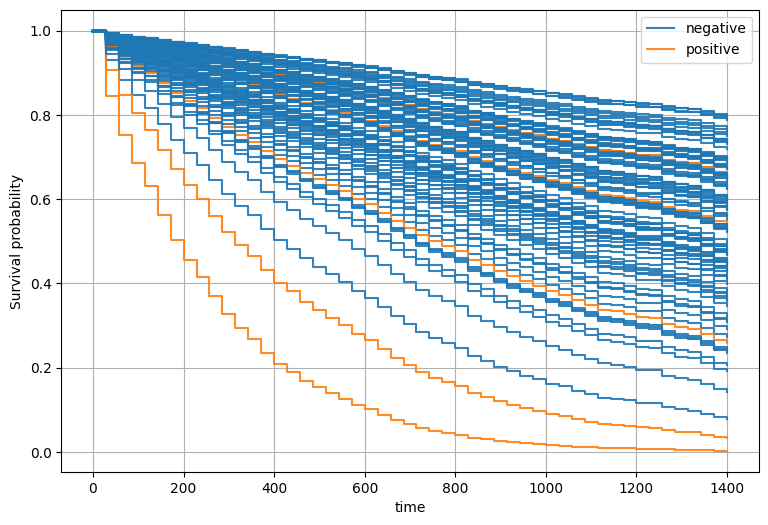

In [53]:
surv_fns = est_early_stopping.predict_survival_function(data_x_test[2500:2600])

time_points =  np.linspace(0, 1400)
#time_points = np.quantile(y["total_stay"], np.linspace(0, 0.6, 100))
legend_handles = []
legend_labels = []
_, ax = plt.subplots(figsize=(9, 6))
for fn, label in zip(surv_fns, test_sepsis[2500:2600]):
    (line,) = ax.step(time_points, fn(time_points), where="post", color=f"C{label}", alpha=0.9)
    
    if len(legend_handles) <= label:
        name = "positive" if label == 1 else "negative"
        legend_labels.append(name)
        legend_handles.append(line)

ax.legend(legend_handles, legend_labels)
ax.set_xlabel("time")
ax.set_ylabel("Survival probability")
ax.grid(True)

# 3.Clustering Model

# 4.Model Testing

# 5.Local and Global Feature Explanation